# Implementing the Ahnert and Payne scheme for a general 1-qubit  POVM on qiskit.



## Introduction

### POVM

### Ahnert Payne

#### ![Image of Yaktocat](https://www.groundai.com/media/arxiv_projects/334479/POVM.png.750x0_q75_crop.png)

### Implementation, general idea

In [2]:
# additional useful packages
import numpy as np
import numpy.np.pi as pi
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.backends.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram


### Constructing a doubly controlled rotation gate

Before start constructing the Ahnert Payne POVM, we will create a quantum circuit performing a doubly controlled rotation on the target qubit, if the two control qubits are $ |1 \rangle$. The allowed rotations will be either z-only or y-only, unlike the qiskit u3() operation, which can perform general multi-axial rotation. However performing combinations of doubly-controlled z- and y-rotationns, we will be able to perform any doubly-controlled operation. We will need this operation when performing the t-branches operations.

Given a rotation axis $ i \in \{y,z\}$, angle $\theta$, control qubit $ q_{ctrl1}$ and $q_{ctrl2}$ and target qubit $  q_{target}$ we perform:
$ doubleCU1(i, \theta, q_{ctrl1}, q_{ctrl2}, q_{target}) =  C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}( - \frac{\theta}{2}) C_{cx}(q_{ctrl1}, q_{ctrl2}, q_{target}) R_{i}(\frac{\theta}{2}) $   
where $C_{cx} $ is the Toffoli gate. 

The reasoning being, that if the two control bits are $ |1 \rangle$, the two Toffoli gate will effectively "flip" the sign of the $-\frac{\theta}{2}$ rotation hence it will add up the the first $\frac{\theta}{2}$ rotation, resulting in a total rotation of $ \theta $. Conversely if any of the control bits is not $ |1 \rangle$, the sign of the second rotation will not be flipped and both rotations will cancel out.  Note that this true only if perform single axis rotation.

In [29]:
# Doubly controlled single axis rotation gate

def double_CU1(axis, angle, q_circuit, ctrl_q1, ctrl_q2, target_q):
    """ Adds a doubly controlled rotation gate to an existing quantum circuit.
    Valid values for axis: 'y' and 'z' (any rotation can be specified by Y and
    Z rotations only).
    """
    if axis == 'y':
        q_circuit.u3(angle/2, 0, 0, target_q)
        q_circuit.ccx(ctrl_q1, ctrl_q2, target_q)
        q_circuit.u3(-angle/2, 0, 0, target_q)
        q_circuit.ccx(ctrl_q1, ctrl_q2, target_q)
    elif axis == 'z':
        q_circuit.u3(0,0,angle/2, target_q)
        q_circuit.ccx(ctrl_q1, ctrl_q2, target_q)
        q_circuit.u3(0,0,-angle/2, target_q)
        q_circuit.ccx(ctrl_q1, ctrl_q2, target_q)
    else:
        raise ValueError('Rotational axis not valid')
        

### 2 part POVM; choose $ | \psi> = \frac{(|0> + \sqrt{3}|1>)}{2}$ ,$ U = I$, $ V_1 = V_2 = I$ and $ \phi_1 = \phi_2 =0$ 

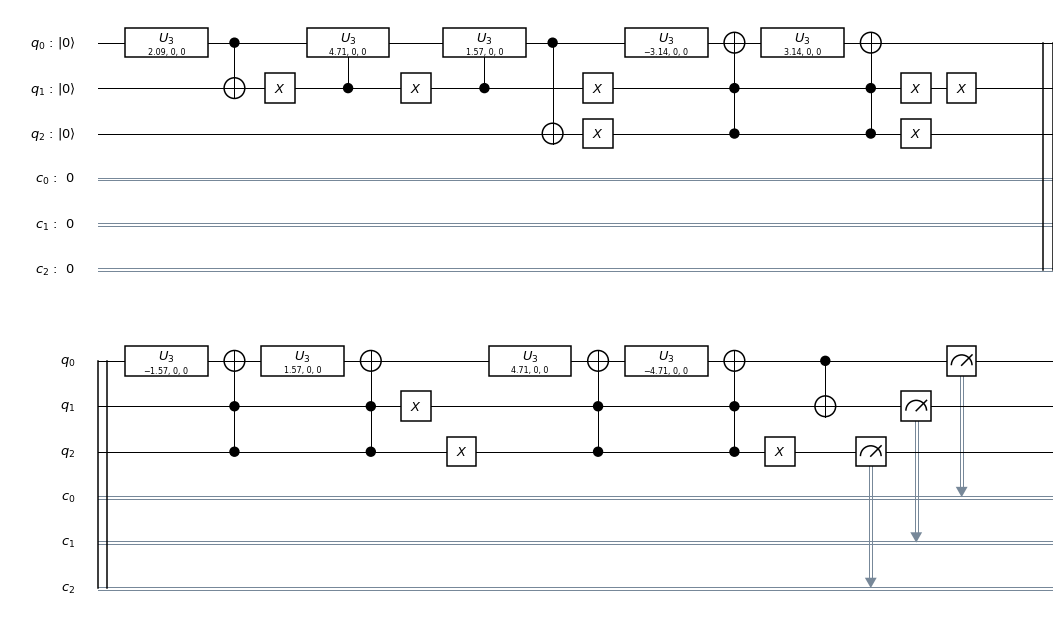

In [4]:
  

# Create a Quantum Register with 3 qubits.
q = QuantumRegister(3, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# prepare the input state (the input state will be represented by qubit 0)
qc.u3(np.pi*2/3, 0 ,0, q[0])
qc.barrier(q)

# Split in paths p1 and p2
qc.cx(q[0],q[1])
qc.barrier(q)
# Apply the rotations along p1 and p2

tita = np.pi/4
phy =- np.pi/4

# controlled rotation if qubit 1 is ZERO
qc.x(q[1])
qc.cu3(2*(tita + np.pi/2),0,0,q[1],q[0])
qc.x(q[1])
qc.barrier(q)

# controlled rotation if qubit 1 is ONE
qc.cu3(2*phy,0,0,q[1],q[0])
qc.barrier(q)

# Split along t1,t2,t3,t4
qc.cx(q[0],q[2])
qc.barrier(q)

# t1 operations: 2*Pi y rotation
qc.x(q[2])
qc.x(q[1])
qc.barrier(q)
doubly_CU1('y',-2*np.pi, qc, q[1],q[2],q[0])
qc.barrier(q)
qc.x(q[1])
qc.x(q[2])
qc.barrier(q)

# t2 operations: -Pi y rotation
qc.x(q[1])
qc.barrier(q)
doubly_CU1('y',-np.pi, qc, q[1],q[2],q[0])
qc.barrier(q)
qc.x(q[1])
qc.barrier(q)

# no t3 rotations

# t4 operations: 3*Pi y rotation
qc.x(q[2])
qc.barrier(q)
doubly_CU1('y',3*np.pi, qc, q[1],q[2],q[0])
qc.barrier(q)
qc.x(q[2])
qc.barrier(q)

# recombine t1 and t3 to p1, and t2 and t4 to p2
qc.cx(q[0],q[1])

# print state vector
# backend=Aer.get_backend('statevector_simulator')
# job=qiskit.execute(qc, backend)
# state_vector=job.result().get_statevector(qc)
# qiskit.tools.visualization.plot_state(state_vector)

# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(3, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)


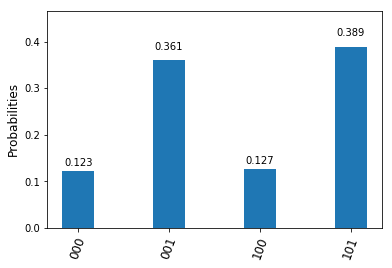

In [15]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8096

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

In [26]:
# REAL DEVICE EXPERIMENT

# IBMQ.save_account(token)
IBMQ.load_accounts()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 
n_qubits = 3


large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] == 5 and
                                                       not x.configuration()['simulator'])
backend = least_busy(large_enough_devices)
# backend = IBMQ.backends(filters=lambda x: x.name == 'ibmqx5')
# print("The best backend is " + backend.name())

job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)

In [27]:

# execute
result = job_exp.result()


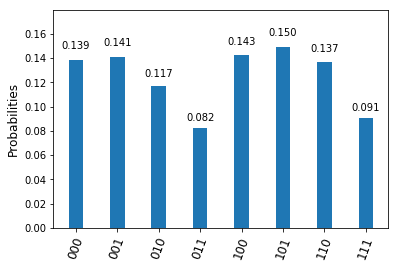

In [28]:
counts = result.get_counts(qc)
plot_histogram(counts)


In [9]:
0.380/0.229


1.6593886462882095